# Image generation

We have embeddings of the keywords of hundreds of popular movies and a GAN trained on completely unrelated images. Let's use the GAN to generate images from the movie keywords!

In [1]:
import pandas as pd
import numpy as np
import torch
from dcgan import Generator
%matplotlib inline
import matplotlib.pyplot as plt
import os
import shutil
from skimage.io import imsave

In [2]:
movies = pd.read_csv('movies/processed.csv')
movie_vectors = np.array([np.fromstring(vector, sep=' ') for vector in movies['vector']])
print(f'movie_vectors: shape {movie_vectors.shape}, std {movie_vectors.std()}')

movie_vectors: shape (257, 257), std 0.1314446645537084


In [3]:
generator = Generator(ngpu=0).eval()
state_dict = torch.load('gan-pretrained-pytorch/cifar10_dcgan/weights/netG_epoch_199.pth', map_location=torch.device('cpu'))
generator.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
latent_size = 100
image_seeds = movie_vectors[:, :latent_size] / movie_vectors[:, :latent_size].std()
image_seeds = torch.tensor(image_seeds, dtype=torch.float)
image_seeds = image_seeds.view(*image_seeds.shape, 1, 1)
images = generator(image_seeds).detach().numpy()
images = images.reshape(images.shape[0], 3, 32, 32)
images = images.transpose((0, 2, 3, 1))
images = (images + 1) / 2 # the generator outputs images within [-1, 1]

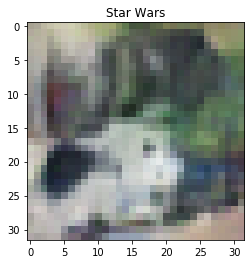

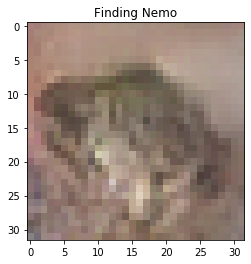

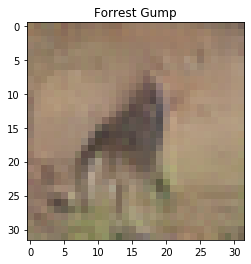

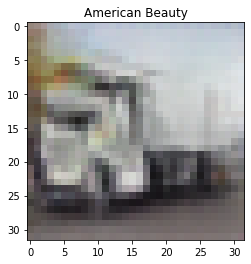

In [5]:
for image, (index, row) in zip(images[:4], movies.iterrows()):
    plt.title(row['title'])
    plt.imshow(image)
    plt.show()

In [6]:
output_dir = 'generated'
shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

for image, (index, row) in zip(images, movies.iterrows()):
    filename = ''.join(char for char in row['title'] if char.isalnum() or char == ' ')
    image_uint8 = (image * 255.5).astype(np.uint8)
    imsave(f'{output_dir}/{filename}.png', image_uint8)

/home/malyvsen/creative/software/ai/inverse-ai/inverse-ai-venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: generated/Batman Begins.png is a low contrast image
  
